In [9]:
%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install matplotlib yfinance scikit-learn scikit-optimize


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from river import metrics

# Importando as classes refatoradas
from utils.SeriesProcessor import SeriesProcessor
from utils.ModelTrainer import ModelTrainer
from utils.DriftEvaluator import DriftEvaluator
from utils.Visualizer import Visualizer
from utils.Optimizer import Optimizer
from utils.SaveCSV import SaveCSV
import pandas as pd

# Importando as classes existentes de otimização
from classes.otimizador.OtimizadorBayesiano import OtimizadorBayesiano

# 1. Importar os modelos e detectores de drift

In [12]:
# Importando detectores de drift
from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
from classes.detectores.KSWINDetector import KSWINDetector

# Importando modelos offline
from classes.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from classes.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from classes.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from classes.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from classes.modelosOffline.SVRModelo import SVRModelo
from classes.modelosOffline.RandomForestModelo import RandomForestModelo
from classes.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

# Importando modelos online
from classes.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from classes.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from classes.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from classes.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo

# 2. Baixar e preparar os dados

In [13]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

In [14]:
# Definindo parâmetros para processamento
tamanho_batch = 50
lags = 5
serie_escolhida = series[-2]
print(f"Processando série: {serie_escolhida}")

# Baixando os dados da ação
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

Processando série: ^BVSP


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1245, 1)
Shape dos dados de entrada: (1240, 5)
Shape dos dados de saída: (1240, 1)


# 3. Otimização de Hiperparâmetros

In [15]:
# Controle para executar ou pular otimização
executar_otimizacao = False #Mude para True quando quiser otimizar novamente

if executar_otimizacao:
    # Lista de modelos a otimizar (classes)
    modelos_offline = [
        LinearRegressionModelo,
        KNeighborsRegressorModelo,
        LassoRegressionModelo,
        #MLPRegressorModelo,  # Comentado por ser mais lento
        RandomForestModelo,
        RidgeRegressionModelo,
        SVRModelo
    ]

    modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

    # Inicializar o otimizador
    optimizer = OtimizadorBayesiano(n_iter=20, cv=3, random_state=42)

    # Otimizando todos os modelos
    modelos_otimizados, parametros_otimizados = Optimizer.otimizar_modelos_offline(
        X, Y, tamanho_batch, lags=lags, optimizer=optimizer,
        modelos_offline=modelos_offline,
    )

    # Salvar parâmetros otimizados para uso futuro
    import json
    with open('parametros_otimizados.json', 'w') as f:
        # Converter valores não serializáveis para strings
        params_serializaveis = {}
        for modelo, params in parametros_otimizados.items():
            params_serializaveis[modelo] = {k: str(v) for k, v in params.items()}
        json.dump(params_serializaveis, f, indent=4)

    print("Parâmetros otimizados salvos em 'parametros_otimizados.json'")
else:
    # Carregar parâmetros já otimizados
    import json
    import os
    import ast

    if os.path.exists('parametros_otimizados.json'):
        with open('parametros_otimizados.json', 'r') as f:
            params_carregados = json.load(f)

        # Convertendo strings de volta para valores adequados
        parametros_otimizados = {}
        for modelo, params in params_carregados.items():
            parametros_otimizados[modelo] = {}
            for k, v in params.items():
                # Tenta converter strings para valores Python
                try:
                    parametros_otimizados[modelo][k] = ast.literal_eval(v)
                except (ValueError, SyntaxError):
                    # Se falhar, mantém como string
                    parametros_otimizados[modelo][k] = v

        # Instanciando modelos com parâmetros otimizados
        modelos_otimizados = {}

        # Dicionário para mapear nomes de classes para referências reais de classes
        classes_modelos = {
            cls.__name__: cls for cls in
            [LinearRegressionModelo, KNeighborsRegressorModelo, LassoRegressionModelo,
             RandomForestModelo, RidgeRegressionModelo, SVRModelo,
             BayesianLinearRegressionModelo, HoeffdingTreeRegressorModelo,
             KNNRegressorOnlineModelo, LinearRegressionOnlineModelo]
        }

        for nome_modelo, params in parametros_otimizados.items():
            # Extrai o nome da classe do nome do modelo
            nome_classe = nome_modelo.split('_')[0]
            if nome_classe in classes_modelos:
                classe_modelo = classes_modelos[nome_classe]
                modelos_otimizados[nome_modelo] = classe_modelo(**params)
            else:
                print(f"Aviso: Classe {nome_classe} não encontrada!")

        print(f"Carregados {len(modelos_otimizados)} modelos com parâmetros otimizados")
    else:
        print("Arquivo de parâmetros não encontrado. Execute a otimização primeiro.")

Carregados 6 modelos com parâmetros otimizados


# 4. Executando Avaliação Prequential com Detecção de Drift

In [16]:
detector_escolhido = ADWINDetector

# Executando prequential com os modelos otimizados
resultados = {}
deteccoes_por_modelo = {}
dados_para_csv = []

for nome_modelo, modelo in modelos_otimizados.items():
    print(f"\nExecutando prequential para {nome_modelo}...")

    predicoes, deteccoes, mae, desvio_padrao = DriftEvaluator.prequential_batch(X, Y, tamanho_batch, modelo_classe=type(modelo), detector_classe=detector_escolhido)
    resultados[nome_modelo] = predicoes
    deteccoes_por_modelo[nome_modelo] = deteccoes
    num_deteccoes = len(deteccoes)

    print(f"Número de detecções para {nome_modelo}: {num_deteccoes}")

    dados_para_csv.append({
        'Modelo': nome_modelo,
        'Numero_Deteccoes': num_deteccoes,
        'MAE_Medio': mae.get(),
        'Std_Dev_Medio': desvio_padrao
    })

SaveCSV.salvar_resultados_csv(
    dados_para_csv,
    'resultados_prequential_deteccoes'
)


Executando prequential para LinearRegressionModelo...


TypeError: LinearRegressionModelo.treinar() missing 1 required positional argument: 'y'


Nenhum drift detectado para LinearRegressionModelo.

Drift detectado para KNeighborsRegressorModelo nos índices: [176, 416, 912]

Drift detectado para LassoRegressionModelo nos índices: [176, 384, 720, 960]

Drift detectado para RandomForestModelo nos índices: [176, 672, 944]

Nenhum drift detectado para RidgeRegressionModelo.

Drift detectado para SVRModelo nos índices: [176, 416, 656, 928]


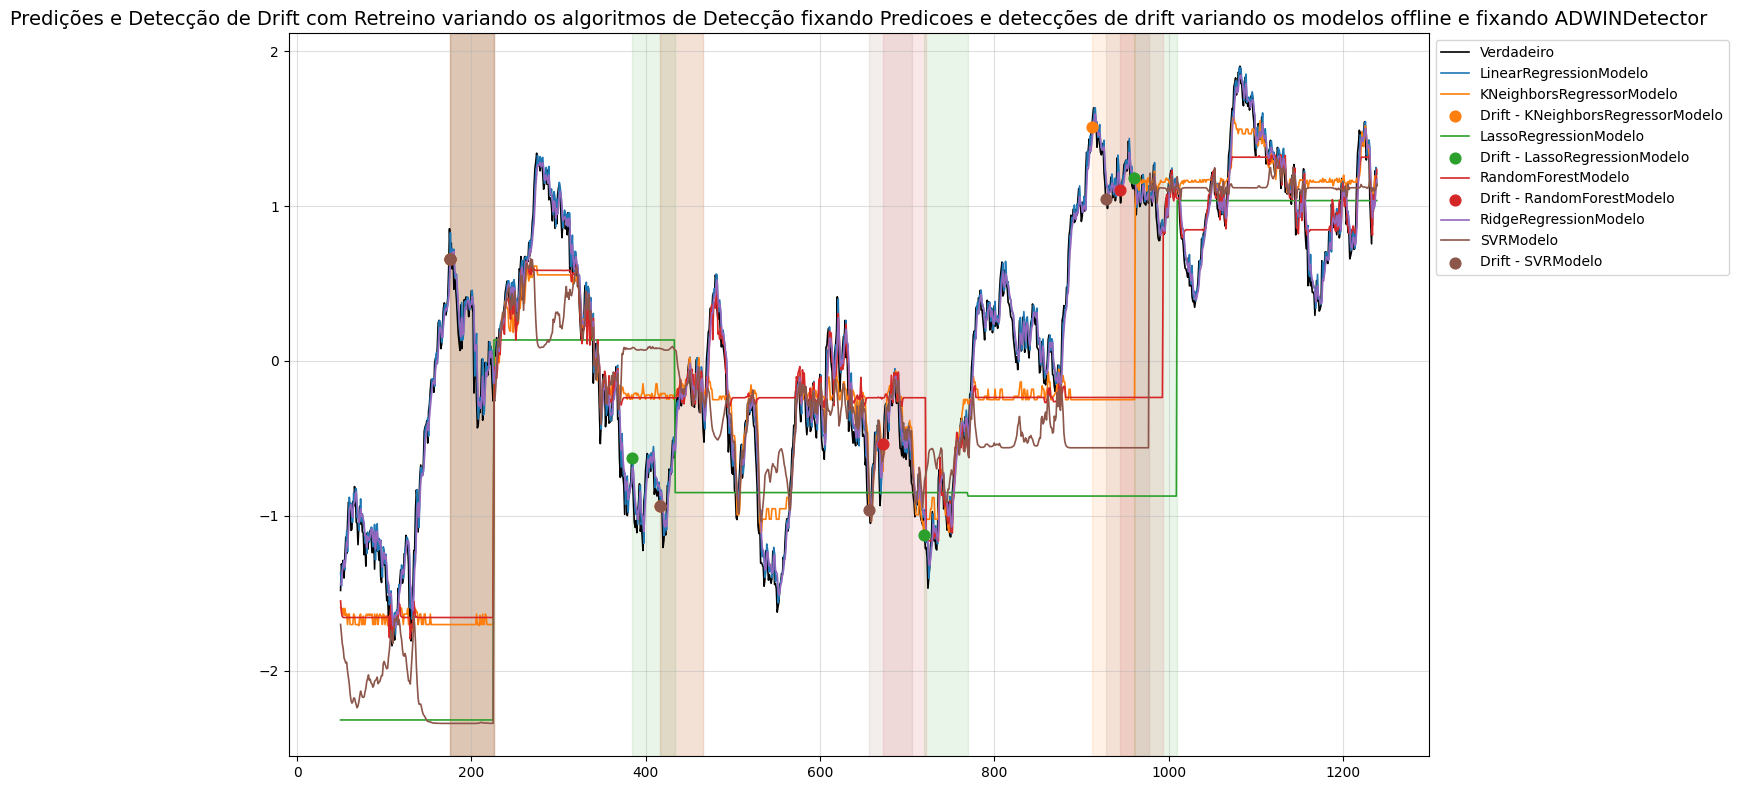

In [ ]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  list(resultados.values()),
                  list(resultados.keys()),
                  deteccoes_por_modelo,
                  tamanho_batch,
                  detector_or_modelo="Predicoes e detecções de drift variando os modelos offline e fixando ADWINDetector",
                  )

# 5. Comparação de Detectores de Drift

In [ ]:
modelo_escolhido = RandomForestModelo
print(f"Modelo selecionado para testes comparativos: {modelo_escolhido.__name__}")

# Lista de detectores a testar
detectores = [
    ADWINDetector,
    #DDMDetector,
    EDDMDetector,
    FHDDMDetector,
    HDDM_ADetector,
    PageHinkleyDetector,
    HDDM_WDetector,
    KSWINDetector
]

# Certifique-se que Y seja um array NumPy 1D, se necessário para prequential_batch
# y_true = np.array(Y).ravel() # Pode não ser necessário se prequential_batch lida com isso

resultados_detectores = {}
deteccoes_detectores = {}
dados_detectores_csv = []

for detector_classe in detectores:
    nome_detector = detector_classe.__name__
    print(f"\nTestando {nome_detector} com {modelo_escolhido.__name__}...")

    predicoes, deteccoes, mae_result, desvio_padrao_result = DriftEvaluator.prequential_batch(
        X, Y, tamanho_batch, modelo_classe=modelo_escolhido, detector_classe=detector_classe
    )

    resultados_detectores[nome_detector] = predicoes
    deteccoes_detectores[nome_detector] = deteccoes
    num_deteccoes = len(deteccoes)

    mae_valor = np.nan
    std_valor = np.nan
    try:
        temp_mae = mae_result.get() if hasattr(mae_result, 'get') else mae_result
        if isinstance(temp_mae, (list, np.ndarray)) and len(temp_mae) > 0:
            temp_mae = temp_mae[0]
        mae_valor = float(temp_mae)

        temp_std = desvio_padrao_result.get() if hasattr(desvio_padrao_result, 'get') else desvio_padrao_result
        if isinstance(temp_std, (list, np.ndarray)) and len(temp_std) > 0:
            temp_std = temp_std[0]
        std_valor = float(temp_std)

        print(f"  MAE Médio (retornado): {mae_valor:.4f}")
        print(f"  Desvio Padrão Médio dos Erros (retornado): {std_valor:.4f}")

    except (TypeError, IndexError, ValueError, AttributeError) as e:
        print(f"  Aviso: Não foi possível extrair valor numérico para MAE/StdDev retornado para {nome_detector}. Erro: {e}")

    print(f"  Número de detecções: {num_deteccoes}")

    dados_detectores_csv.append({
        'Detector': nome_detector,
        'MAE_Medio': mae_valor,
        'Std_Dev_Medio': std_valor,
        'Numero_Deteccoes': num_deteccoes
    })


df_resultados_detectores = pd.DataFrame(dados_detectores_csv)

nome_arquivo_csv_detectores = 'resultados_detectores_metricas.csv'
df_resultados_detectores.to_csv(nome_arquivo_csv_detectores, index=False, float_format='%.6f', na_rep='NaN')

print(f"\nResultados dos detectores salvos em {nome_arquivo_csv_detectores}")

print("\nResumo dos Resultados por Detector (Formatado):")

df_formatado_detectores = df_resultados_detectores.copy()

colunas_para_formatar = ['MAE_Medio', 'Std_Dev_Medio']
for col in colunas_para_formatar:
    if col in df_formatado_detectores.columns and pd.api.types.is_numeric_dtype(df_formatado_detectores[col]):
         df_formatado_detectores[col] = df_formatado_detectores[col].apply(lambda x: f'{x:.3f}' if pd.notna(x) else 'NaN')

print(df_formatado_detectores.to_string(index=False))

Modelo selecionado para testes comparativos: RandomForestModelo

Testando ADWINDetector com RandomForestModelo...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 176, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 175 até 225.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 416, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 415 até 465.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 912, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 911 até 961.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x17e6c46b0>
Detector utilizado: <classes.detectores.ADWINDetector.ADWINDetector object at 0x17fbc0230>
MAE Modelo Batch: 0.4346827641585356
Desvio Padrão dos Erros: 0.4821861396133783
  MAE Médio (retornado): 0.4347
  Desvio Padrão Médio dos Erros (retornado): 0.4822
  Número de detecções: 3

Testando EDDMDetector com RandomForestModelo...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x17f653f20>
Detector utilizado: <classes.detectores.EDDMDetector.EDDMDetector object at 0x17f651700>
MAE Modelo Batch: 1.7270310207272372
Desvio Padrão dos Erros: 0.8631533548062128
  MAE Médio (retornado): 1.7270
  Desvio Padrão Médio dos Erros (retornado): 0.8632
  Número de detecções: 0

Testando FHDDMDetector com RandomForestModelo...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 372, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 371 até 421.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 739, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 738 até 788.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1186, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1185 até 1235.
Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x17f54acc0>
Detector utilizado: <classes.detectores.FHDDMDetector.FHDDMDetector object at 0x17cee4440>
MAE Modelo Batch: 0.7829972262617345
Desvio Padrão dos Erros: 0.6832583143296358
  MAE Médio (retornado): 0.7830
  Desvio Padrão Médio dos Erros (retornado): 0.6833
  Número de detecções: 3

Testando HDDM_ADetector com RandomForestModelo...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 149, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 148 até 198.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 292, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 291 até 341.

Mudança detectada no índice 387, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 386 até 436.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 801, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 800 até 850.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 914, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 913 até 963.

Mudança detectada no índice 1036, começando a coletar dados para retreino...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Janela completa com 50 amostras. Retreinado com dados do índice 1035 até 1085.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x17e6c4e90>
Detector utilizado: <classes.detectores.HDDM_ADetector.HDDM_ADetector object at 0x17fbc2d20>
MAE Modelo Batch: 0.394066912267663
Desvio Padrão dos Erros: 0.422247882572922
  MAE Médio (retornado): 0.3941
  Desvio Padrão Médio dos Erros (retornado): 0.4222
  Número de detecções: 6

Testando PageHinkleyDetector com RandomForestModelo...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 184, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 183 até 233.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 983, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 982 até 1032.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x17fab2300>
Detector utilizado: <classes.detectores.PageHinkleyDetector.PageHinkleyDetector object at 0x17faf4560>
MAE Modelo Batch: 0.4944195073728645
Desvio Padrão dos Erros: 0.4867739443548413
  MAE Médio (retornado): 0.4944
  Desvio Padrão Médio dos Erros (retornado): 0.4868
  Número de detecções: 2

Testando HDDM_WDetector com RandomForestModelo...

Mudança detectada no índice 153, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 152 até 202.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 389, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 388 até 438.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 810, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 809 até 859.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1078, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1077 até 1127.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x17fc54560>
Detector utilizado: <classes.detectores.HDDM_WDetector.HDDM_WDetector object at 0x17fc54d70>
MAE Modelo Batch: 0.4509640519682971
Desvio Padrão dos Erros: 0.4276830418895095
  MAE Médio (retornado): 0.4510
  Desvio Padrão Médio dos Erros (retornado): 0.4277
  Número de detecções: 4

Testando KSWINDetector com RandomForestModelo...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 152, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 151 até 201.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 300, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 299 até 349.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 450, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 449 até 499.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 599, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 598 até 648.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 747, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 746 até 796.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 895, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 894 até 944.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1043, começando a coletar dados para retreino...
Janela completa com 50 amostras. Retreinado com dados do índice 1042 até 1092.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Mudança detectada no índice 1191, começando a coletar dados para retreino...
Modelo utilizado: <classes.modelosOffline.RandomForestModelo.RandomForestModelo object at 0x17fbfea50>
Detector utilizado: <classes.detectores.KSWINDetector.KSWINDetector object at 0x17facc8c0>
MAE Modelo Batch: 0.3692946292236025
Desvio Padrão dos Erros: 0.4222205143240375
  MAE Médio (retornado): 0.3693
  Desvio Padrão Médio dos Erros (retornado): 0.4222
  Número de detecções: 8

Resultados dos detectores salvos em resultados_detectores_metricas.csv

Resumo dos Resultados por Detector (Formatado):
           Detector MAE_Medio Std_Dev_Medio  Numero_Deteccoes
      ADWINDetector     0.435         0.482                 3
       EDDMDetector     1.727         0.863                 0
      FHDDMDetector     0.783         0.683                 3
     HDDM_ADetector     0.394         0.422                 6
PageHinkleyDetector     0.494         0.487                 2
     HDDM_WDetector     0.451         0.428  


Drift detectado para ADWINDetector nos índices: [176, 416, 912]

Nenhum drift detectado para EDDMDetector.

Drift detectado para FHDDMDetector nos índices: [372, 739, 1186]

Drift detectado para HDDM_ADetector nos índices: [149, 292, 387, 801, 914, 1036]

Drift detectado para PageHinkleyDetector nos índices: [184, 983]

Drift detectado para HDDM_WDetector nos índices: [153, 389, 810, 1078]

Drift detectado para KSWINDetector nos índices: [152, 300, 450, 599, 747, 895, 1043, 1191]


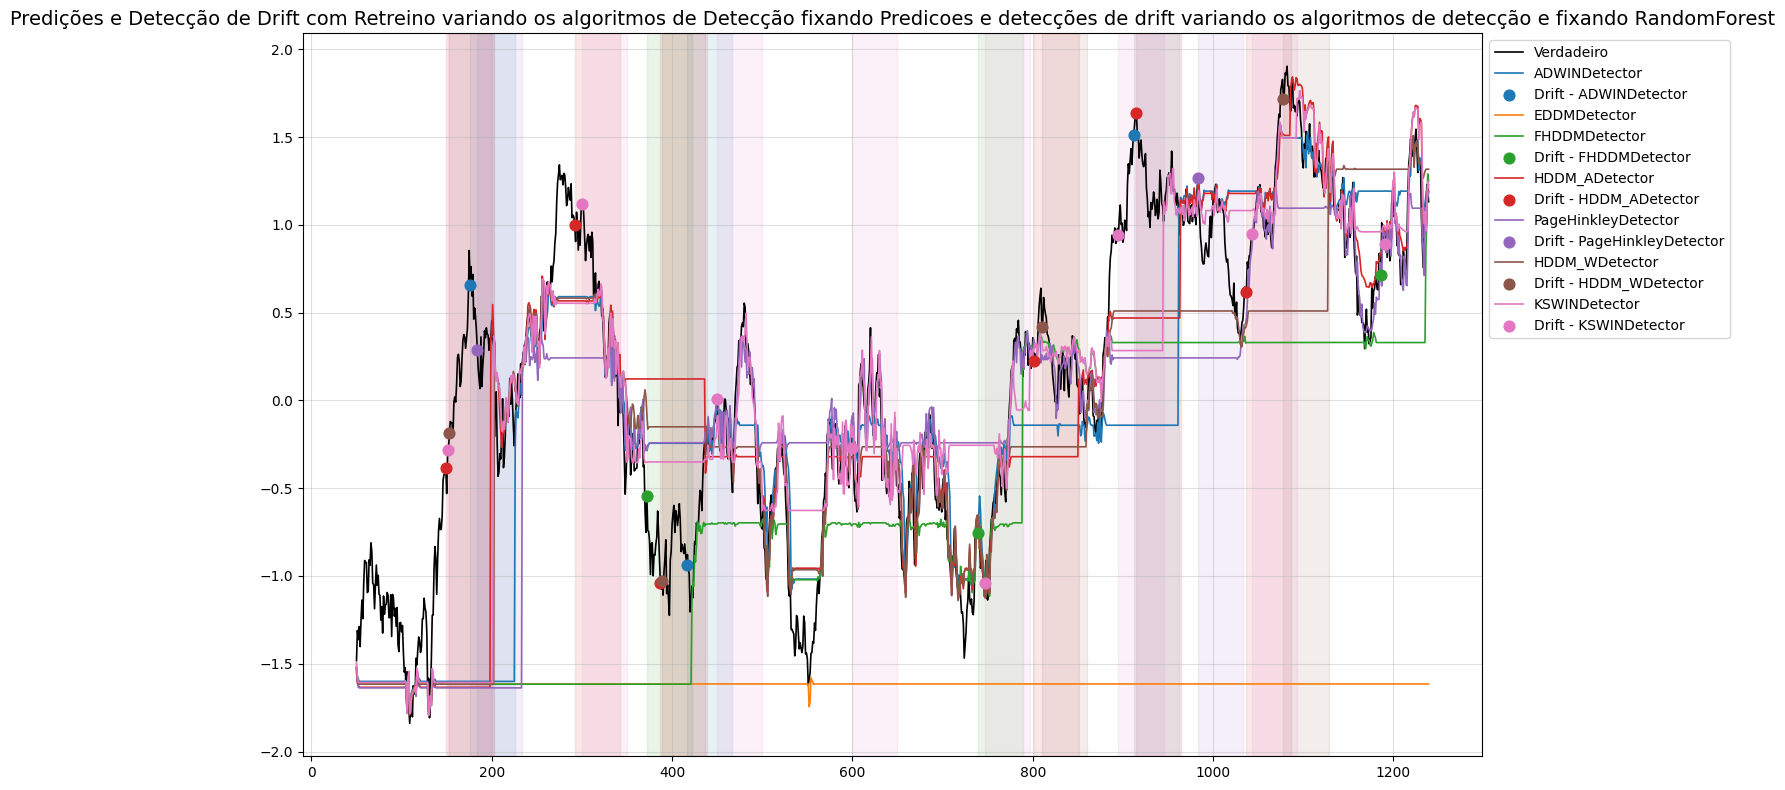

In [ ]:
Visualizer.plotar_resultados_multi(Y,
                  list(resultados_detectores.values()),
                  list(resultados_detectores.keys()),
                  deteccoes_detectores,
                  tamanho_batch,
                  detector_or_modelo="Predicoes e detecções de drift variando os algoritmos de detecção e fixando RandomForest",
                  )

# 6. Resultado dos Modelos Online

In [ ]:
resultados = {}
deteccoes_por_modelo = {}
dados_para_csv = []

modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

for modelo_classe in modelos_online:
    print(f"\nExecutando prequential para {modelo_classe.__name__}...")

    predicoes, mae, desvio_padrao = DriftEvaluator.prequential_passivo(X, Y, tamanho_batch, modelo_classe)
    resultados[modelo_classe.__name__] = predicoes

    dados_para_csv.append({
        'Modelo': modelo_classe.__name__,
        'MAE_Medio': mae.get(),
        'Std_Dev_Medio': desvio_padrao
    })

SaveCSV.salvar_resultados_csv(
    dados_para_csv=dados_para_csv,
    nome_arquivo_csv='resultados_prequential_passivo2'
)


Executando prequential para BayesianLinearRegressionModelo...
Modelo utilizado: <classes.modelosOnline.BayesianLinearRegressionModelo.BayesianLinearRegressionModelo object at 0x17fc6d7f0>
MAE Modelo Online: 0.09084450501804595

Executando prequential para HoeffdingTreeRegressorModelo...
Modelo utilizado: <classes.modelosOnline.HoeffdingTreeRegressorModelo.HoeffdingTreeRegressorModelo object at 0x17f7b82f0>
MAE Modelo Online: 0.11459542588955261

Executando prequential para KNNRegressorOnlineModelo...
Modelo utilizado: <classes.modelosOnline.KNNRegressorOnlineModelo.KNNRegressorOnlineModelo object at 0x17f6526c0>
MAE Modelo Online: 0.1197968335753466

Executando prequential para LinearRegressionOnlineModelo...
Modelo utilizado: <classes.modelosOnline.LinearRegressionOnlineModelo.LinearRegressionOnlineModelo object at 0x17ffdfb00>
MAE Modelo Online: 0.11459542588955261

Resultados salvos em resultados_prequential_passivo2.csv

Resumo dos Resultados:
                           Modelo  MA


Nenhum drift detectado para BayesianLinearRegressionModelo.

Nenhum drift detectado para HoeffdingTreeRegressorModelo.

Nenhum drift detectado para KNNRegressorOnlineModelo.

Nenhum drift detectado para LinearRegressionOnlineModelo.


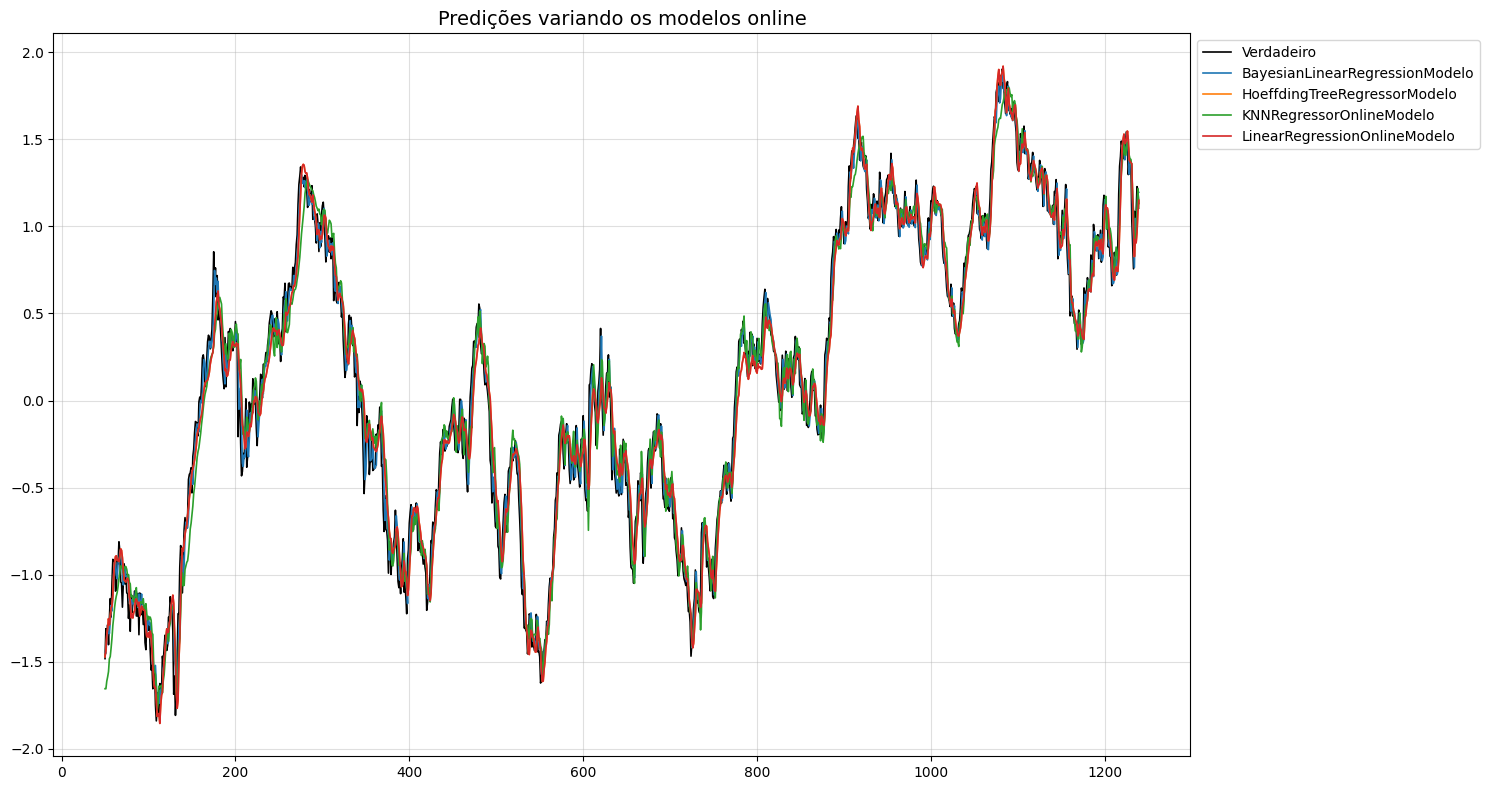

In [ ]:
Visualizer.plotar_resultados(
    Y,
    list(resultados.values()),
    list(resultados.keys()),
    deteccoes_por_modelo={},
    tamanho_batch=tamanho_batch,
    titulo_plot="Predições variando os modelos online",
)